# Generating rules with different complexity

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import aix360.algorithms.rbm
from aix360.algorithms.rbm import FeatureBinarizer
from aix360.algorithms.rbm import BooleanRuleCG

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import metrics
# ignore warning related to deprecated modules inside packages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
# train with fixed seed to eliminate different results
np.random.seed(777)

In [7]:
data = pd.read_csv("../datasets/phone-price/test.csv")

In [8]:
data.columns

Index(['id', 'battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc',
       'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc',
       'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi'],
      dtype='object')

In [10]:
categorical_features = ['blue', 'dual_sim', 'four_g','three_g', 'touch_screen', 'wifi']
fb = FeatureBinarizer(colCateg=categorical_features, negations=True, returnOrd=True)

X_bin, X_std = fb.fit_transform(data)

In [17]:
Y = data["status"].map(lambda x: 1 if x == "Placed" else 0).astype(int)

In [18]:
def explain_with_BRCG(X, y, CNF=False, lambda0=1e-2, lambda1=1e-3, verbose=True):
    # Instantiate BRCG with small complexity penalty
    br_model = BooleanRuleCG(lambda0, lambda1, CNF=False)
    # Train, print, and evaluate model
    br_model.fit(X, y)
    if verbose:
        print('Training accuracy:', metrics.accuracy_score(y, br_model.predict(X)))
    if br_model.CNF:
        print('Predict Y=0 if ANY of the following rules are satisfied, otherwise Y=1:')
    else:
        print('Predict Y=1 if ANY of the following rules are satisfied, otherwise Y=0:')
    print(br_model.explain()['rules'])
    return br_model

In [19]:
rules = explain_with_BRCG(X_bin, Y)

Learning DNF rule with complexity parameters lambda0=0.01, lambda1=0.001
Initial LP solved
Iteration: 1, Objective: 0.1970
Iteration: 2, Objective: 0.1664
Iteration: 3, Objective: 0.1587
Iteration: 4, Objective: 0.1505
Iteration: 5, Objective: 0.1417
Iteration: 6, Objective: 0.1359
Iteration: 7, Objective: 0.1251
Iteration: 8, Objective: 0.1241
Iteration: 9, Objective: 0.1228
Iteration: 10, Objective: 0.1188
Iteration: 11, Objective: 0.1173
Iteration: 12, Objective: 0.1161
Iteration: 13, Objective: 0.1151
Iteration: 14, Objective: 0.1143
Iteration: 15, Objective: 0.1140
Iteration: 16, Objective: 0.1129
Iteration: 17, Objective: 0.1129
Iteration: 18, Objective: 0.1124
Iteration: 19, Objective: 0.1124
Training accuracy: 0.9302325581395349
Predict Y=1 if ANY of the following rules are satisfied, otherwise Y=0:
['ssc_p > 64.00 AND hsc_p > 65.00', 'ssc_p > 70.00 AND hsc_p <= 62.00', 'hsc_p > 52.00 AND degree_p > 65.00 AND mba_p <= 65.47', 'ssc_p > 52.00 AND hsc_p > 52.00 AND degree_t != Sci

In [20]:
simple_dnf = ['ssc_p > 64.00', 'ssc_p > 52.00 AND hsc_p > 52.00 AND mba_p <= 58.78']

cat_test_dnf = ['ssc_p > 32.00 AND degree_t == Sci&Tech', 'mba_p <= 58.78 AND degree_t == Marketing']

middle_dnf_desc = ['ssc_p > 64.00 AND hsc_p > 65.00', 
                   'ssc_p > 52.00 AND hsc_p > 52.00 AND degree_t != Sci&Tech AND mba_p <= 58.78',
                'ssc_p > 32.00 AND degree_t != Sci&Tech']

middle_dnf_asc = ['ssc_p > 32.00 AND degree_t != Sci&Tech',
                  'ssc_p > 52.00 AND hsc_p > 52.00 AND degree_t != Sci&Tech AND mba_p <= 58.78',
                  'ssc_p > 64.00 AND hsc_p > 65.00']

complex_dnf = ['ssc_p > 64.00 AND hsc_p > 74.73',
 'ssc_p > 52.00 AND ssc_b not  AND workex  ',
 'ssc_p > 67.00 AND degree_p <= 69.58 AND mba_p <= 67.14',
 'hsc_b   AND hsc_s != Commerce AND degree_p > 67.44',
 'ssc_p > 64.00 AND hsc_p > 52.00 AND degree_p > 67.44',
 'hsc_p > 52.00 AND etest_p <= 55.80 AND specialisation  ',
 'hsc_p <= 67.52 AND hsc_p > 52.00 AND etest_p <= 71.00 AND mba_p <= 54.99',
 'gender   AND ssc_p > 52.00 AND degree_p <= 72.13 AND degree_p > 60.00 AND etest_p > 55.80 AND mba_p <= 70.68']


# Creating Boolean Decision Diagrams

## Using the package PyEDA

In [21]:
!/Users/hainb/miniconda3/bin/python -m pip install pyeda

You should consider upgrading via the '/Users/hainb/miniconda3/bin/python -m pip install --upgrade pip' command.


In [1]:
from pyeda.inter import *

## Transforming the terms into logical variables

In [2]:
import random
import string

class LogicalOrdinalValue:
    class Term:
        def __init__(self, expr):
            parts = expr.split()
            if len(parts) != 3:
                raise ValueError
        
            self.value = float(parts[2])
            self.op = parts[1]
            self.attr = parts[0]
            
        def get_expr(self):
            return f"{self.attr} {self.op} {self.value}"
            
            
    def __init__(self, expr, landmarks):
        if(expr.split()[0] not in landmarks.keys()):
            self.term = expr
            self.type = "categorical"
            self.logical_v = None
            self.le = self.name_cat_value(expr)
        else:
            self.term = self.Term(expr)
            self.type = "ordinal"
            self.logical_v = self.v(self.term, landmarks[self.term.attr]).astype(int)
            self.le = f"{self.term.attr}_{self.v2bin(self.logical_v)}"
        
    def v(self, term, landmark):
        value = term.value
        op = term.op
        #ezen meg mindig kell dolgozni....
        result = np.zeros(9)
        for i, thr in enumerate(landmark):
            if op == ">":
                if value < landmark[i]:
                    result[i] = 1
            elif op == "<=":
                if value >= landmark[i]:
                    result[i] = 1
            else: # =
                if value < landmark[i] and i != 0:
                    result[i-1] = 1
                    break
                    
        return result
    
    def v2bin(self, arr):
        return np.sum((2 ** np.arange(arr.shape[0])) * arr ).astype(int)
    
    def name_cat_value(self, expr):
        # naming: attr_c_[in]v
        parts = expr.split()
        op = "i" if len(parts) > 1 and (parts[1] == "==" or parts[1] == "not") else "n"
        if len(parts) == 3:
            c = parts[2].translate(str.maketrans('','',string.punctuation))
        else:
            c = "0"
        return f"{parts[0]}_c_{op}{c}"

In [3]:
class TransformLogical:
    def __init__(self, ruleset, landmark):
        self.landmark = landmark
        self.transformed_rules = []
        for rule in ruleset:
            terms = rule.split(" AND ")
            self.transformed_rules.append([LogicalOrdinalValue(term, landmark) for term in terms])
                
                
    def get_expr(self):
        result = ""
        for rule in self.transformed_rules:
            for terms in rule:
                result += terms.le
                result += " & "
            result = result.rstrip(" & ")
            result += " | "
        return result.rstrip(" | ")
    
    
    def add_ord_impl(self, x, y, const_list):
        dim = len(x.logical_v)
        x_and_y = np.bitwise_and(x.logical_v, y.logical_v)
        mask = np.zeros(dim).astype(int)
        mask[0] = 1
        mask[-1] = 1
        if np.count_nonzero(x_and_y) == 0:
            const_list.append(expr(f"{x.le} <=> ~ {y.le}"))
        elif np.count_nonzero(np.bitwise_and(x_and_y, mask)) != 0:
            if x.v2bin(x.logical_v) < y.v2bin(y.logical_v):
                const_list.append(expr(f"{x.le} => {y.le}"))
        
    
    def make_constraints(self):
        cat_constraints = dict()
        ord_constraints = []
        flat_rules = list(np.concatenate(self.transformed_rules).flat)
        # could be n*logn
        for x in flat_rules:
            if x.type == "categorical":
                attr = x.term.split()[0]
                op = x.le.split('_')[-1].startswith("i")
                if op:
                    if attr not in cat_constraints:
                        cat_constraints[attr] = list()
                    cat_constraints[attr].append(x.le)
            else:
                for y in flat_rules:
                    if y.type == "ordinal" and x.term.attr == y.term.attr and x != y:
                        self.add_ord_impl(x, y, ord_constraints)
                    
        onehot_list = []
        for onehot in cat_constraints.values():
            if len(onehot) > 1:
                onehot_list.append(OneHot0(*onehot))
            
        onehot_expr = And(*onehot_list)
        impl_expr = And(*ord_constraints)
        return onehot_expr
    
    
    def get_expr_w_constraints(self):
        main_expr = expr(self.get_expr())
        constraints = self.make_constraints()
        return And(main_expr, constraints)

In [4]:
s = ['ram > 2479.80', 'battery_power > 1403.00 AND px_width > 669.90 AND ram > 1751.20', 'px_height > 223.00 AND px_width > 1244.00 AND ram > 2129.50']

In [19]:
e = TransformLogical(s, fb.thresh)

In [21]:
e.get_expr_w_constraints()

Or(ram_480, And(ram_504, px_width_510, battery_power_448), And(ram_496, px_width_496, px_height_508))

In [26]:
OneHot0(expr("a"), expr("b"), expr("c"))

And(Or(~a, ~b), Or(~a, ~c), Or(~b, ~c))

In [18]:
s

['ram > 2479.80',
 'battery_power > 1403.00 AND px_width > 669.90 AND ram > 1751.20',
 'px_height > 223.00 AND px_width > 1244.00 AND ram > 2129.50']

In [28]:
mid_logical_desc = expr(e.get_expr())
mid_logical_f_desc = expr2bdd(mid_logical_desc)

### Introducing big ==> small implication

In [ ]:
expr("a=>b")

In [ ]:
mid_imp_desc = And(expr("(ssc_p_496 => ssc_p_511) & (ssc_p_496 => ssc_p_510) & (ssc_p_511 => ssc_p_510)"), mid_logical_desc)

In [ ]:
mid_imp_desc = expr2bdd(mid_imp)

In [ ]:
mid_imp_asc = expr2bdd(And(expr("(ssc_p_496 => ssc_p_511) & (ssc_p_496 => ssc_p_510) & (ssc_p_511 => ssc_p_510)"), mid_f_asc))

## Visualizing the BDD

In [ ]:
!pip3 install gvmagic

In [25]:
import gvmagic
%load_ext gvmagic

### Simple ruleset 

In [ ]:
%dotobj f_simple

### Complex ruleset without implication

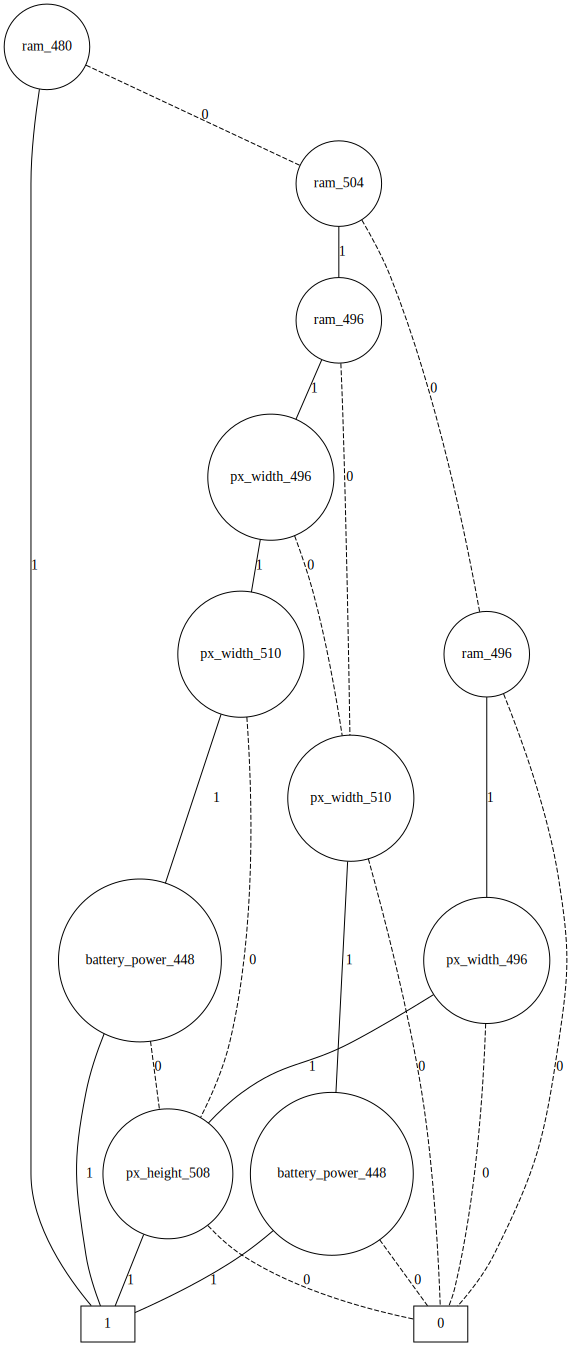

In [29]:
%dotobj mid_logical_f_desc

### Complex ruleset without implication

#### The ruleset as a reminder:


In [ ]:
%dotobj expr2bdd(mid_f_desc.get_expr_w_imp())

### Order does not matter the library will optimise

In [ ]:
%dotobj mid_imp_asc

In [ ]:
expr2truthtable(mid_f_asc)